In [72]:
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt

COLUMNS = ['Date','Total_Cases','New_Daily_Cases','New_Daily_Deaths','Total_Deaths','Total_Recoveries']

In [57]:
import requests
import sys
import csv
import datetime

def generate_csv(code):
    url = "https://thevirustracker.com/free-api?countryTimeline=" + code

    r = requests.get(url, headers={"User-Agent": "XY"})

    data = r.json()
    keys = data['timelineitems'][0].keys()
    length = len(keys)
    name = "covid" + code + ".csv"
    with open(name, 'w', newline='') as file:
                writer = csv.writer(file)
                for key in keys:
                    if length > 2:
                        row = []
                        x = datetime.datetime.strptime(key, '%m/%d/%Y')
                        xn = x - datetime.timedelta(days=1)
                        date = xn.strftime("%m/%d/%Y")
                        row.append(date)
                        row.append(data['timelineitems'][0][key]['total_cases'])
                        row.append(data['timelineitems'][0][key]['new_daily_cases'])
                        row.append(data['timelineitems'][0][key]['new_daily_deaths'])
                        row.append(data['timelineitems'][0][key]['total_deaths'])
                        row.append(data['timelineitems'][0][key]['total_recoveries'])
                        writer.writerow(row)
                        length-=1

In [63]:
generate_csv("PT")
generate_csv("IT")
generate_csv("ES")

In [61]:
dataPT = pd.read_csv('covidPT.csv')
dataPT.columns = COLUMNS
dataPT.head()

,Date,Total_Cases,New_Daily_Cases,New_Daily_Deaths,Total_Deaths,Total_Recoveries
0,03/01/2020,2,2,0,0,0
1,03/02/2020,2,0,0,0,0
2,03/03/2020,5,3,0,0,0
3,03/04/2020,9,4,0,0,0
4,03/05/2020,13,4,0,0,0


In [65]:
dataIT = pd.read_csv('covidIT.csv')
dataIT.columns = COLUMNS
dataES = pd.read_csv('covidES.csv')
dataES.columns = COLUMNS

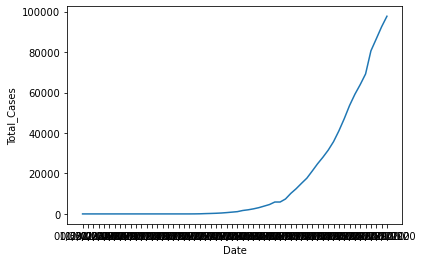

In [77]:
# Visualization
X = dataPT.drop(columns=['New_Daily_Deaths','Date'], axis=0)
y = dataPT['New_Daily_Deaths']

time = dataIT.drop(columns=['New_Daily_Deaths','New_Daily_Cases','Total_Deaths','Total_Recoveries'], axis=0)
time.head()
sb.lineplot('Date','Total_Cases',data=time)

In [68]:
# Linear Regression



from sklearn.linear_model import LinearRegression
model_death = LinearRegression()
model_death.fit(X,y)
new_y = model.predict()

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)